In [0]:
import os
from collections import defaultdict
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

In [0]:
class RNN(nn.Module):
	def __init__(self, input_size, embed_size, hidden_size, output_size, num_layers=1, bidirec=False, device='cuda'):
		super(RNN, self).__init__()

		self.hidden_size = hidden_size
		self.num_layers = num_layers

		if bidirec:								#양방향인경우 어순이 바뀔 수 있는경우?
			self.num_directions = 2
		else:
			self.num_directions = 1

		self.device = device

		self.embed = nn.Embedding(input_size, embed_size, padding_idx=1)
		self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirec)
		self.linear = nn.Linear(hidden_size * self.num_directions, output_size)


	def init_hidden(self, batch_size):										#초기화해줌
		hidden = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size).to(self.device)
		cell = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size).to(self.device)
		return hidden, cell
	
	
	def forward(self, inputs):
		embed = self.embed(inputs)											#embed된것
		hidden, cell = self.init_hidden(inputs.size(0))						#초기화
	
		output, (hidden, cell) = self.lstm(embed, (hidden, cell))

		hidden = hidden[-self.num_directions:]
		hidden = torch.cat([h for h in hidden], 1)
		output = self.linear(hidden)

		return output														#5차원 데이터로 one-hot encoding된 결과


In [0]:
def make_vocab(vocab_path, train=None):
	vocab = {}
	if os.path.isfile(vocab_path):
		file = open(vocab_path, 'r', encoding='utf-8')
		for line in file.readlines():
			line = line.rstrip()
			key, value = line.split('\t')
			vocab[key] = value
		file.close()
	else:
		count_dict = defaultdict(int)															#0으로 초기
		for index, data in tqdm(train.iterrows(), desc='make vocab', total=len(train)):			#게이지 표시
			sentence = data['Phrase'].lower()
			tokens = sentence.split(' ')
			for token in tokens:
				count_dict[token] += 1

		file = open(vocab_path, 'w', encoding='utf-8')
		file.write('[UNK]\t0\n[PAD]\t1\n')
		vocab = {'[UNK]' : 0, '[PAD]' : 1}
		for index, (token, count) in enumerate(sorted(count_dict.items(), reverse=True, key=lambda item: item[1])):				#UNK랑 PAD때문에 + 2
			vocab[token] = index + 2
			file.write(token + '\t' + str(index + 2) + '\n')
		file.close()

	return vocab
	

def read_data(train, test, vocab, max_len):
	x_train = np.ones(shape=(len(train), max_len))												#패딩토큰으로 초기화
	for i, data in tqdm(enumerate(train['Phrase']), desc='make x_train data', total=len(train)):
		data = data.lower()
		tokens = data.split(' ')
		for j, token in enumerate(tokens):
			if j == max_len:
				break
			x_train[i][j] = vocab[token]														#토큰에 따른 값을 넣어줌
	
	x_test = np.ones(shape=(len(test), max_len))
	for i, data in tqdm(enumerate(test['Phrase']), desc='make x_test data', total=len(test)):
		data = data.lower()
		tokens = data.split(' ')
		for j, token in enumerate(tokens):
			if j == max_len:
				break
			if token not in vocab.keys():														#vocab에 없는 토큰에 대한 처리 
				x_test[i][j] = 0
			else:
				x_test[i][j] = vocab[token]

	y_train = train['Sentiment'].to_numpy()

	return x_train, y_train, x_test


def train(x, y, max_len, embed_size, hidden_size, output_size, batch_size, epochs, lr, device, model=None):
	x = torch.from_numpy(x).long()
	y = torch.from_numpy(y).long()
	if model is None:
		model = RNN(max_len, embed_size, hidden_size, output_size, device=device)
	model.to(device)																	#device 명시
	model.train()
	loss_function = nn.CrossEntropyLoss()
	optimizer = optim.Adam(model.parameters(), lr=lr)
	data_loader = torch.utils.data.DataLoader(list(zip(x, y)), batch_size, shuffle=True)
	loss_total = []
	acc_total = []

	for epoch in trange(epochs):
		epoch_loss = 0
		epoch_acc = 0
		for batch_data in data_loader:
			x_batch, y_batch = batch_data
			x_batch = x_batch.to(device)												#device 명시. 맞춰줘야함
			y_batch = y_batch.to(device)

			pred = model(x_batch)

			loss = loss_function(pred, y_batch)
			optimizer.zero_grad()
			loss.backward()

			optimizer.step()

			epoch_loss += loss.item()
			epoch_acc += get_acc(pred, y_batch)
		epoch_loss /= len(data_loader)
		epoch_acc /= len(data_loader)
		loss_total.append(epoch_loss)
		acc_total.append(epoch_acc)
		print('\nEpoch [%d] Loss : %.3f\t Acc : %.3f' % (epoch + 1, epoch_loss, epoch_acc))

	torch.save(model, 'model.out')

	return model, loss_total, acc_total


def get_acc(pred, answer):
	correct = 0
	for p, a in zip(pred, answer):
		pv, pi = p.max(0)
		if pi == a:
			correct += 1
	
	return correct / len(pred)


def test(model, x, batch_size, device):
	model.to(device)
	model.eval()
	x = torch.from_numpy(x).long()
	data_loader = torch.utils.data.DataLoader(x, batch_size, shuffle=False)

	predict = []
	for batch_data in data_loader:
		batch_data = batch_data.to(device)
		pred = model(batch_data)
		for p in pred:
			pv, pi = p.max(0)
			predict.append(pi.item())

	return predict


def draw_graph(data):
	plt.plot(data)
	plt.show()


def save_submission(pred):
	data = {
		'PhraseId' : np.arange(156061, 156061 + len(pred)),
		'Sentiment' : pred
	}
	df = pd.DataFrame(data)
	df.to_csv('data/my_submission.csv', mode='w', index=False)

 10%|█         | 1/10 [00:10<01:31, 10.20s/it]


Epoch [1] Loss : 1.282	 Acc : 0.504


 20%|██        | 2/10 [00:20<01:21, 10.19s/it]


Epoch [2] Loss : 1.178	 Acc : 0.523


 30%|███       | 3/10 [00:30<01:11, 10.20s/it]


Epoch [3] Loss : 1.117	 Acc : 0.548


 40%|████      | 4/10 [00:40<01:01, 10.22s/it]


Epoch [4] Loss : 1.064	 Acc : 0.567


 50%|█████     | 5/10 [00:51<00:51, 10.25s/it]


Epoch [5] Loss : 1.018	 Acc : 0.587


 60%|██████    | 6/10 [01:01<00:40, 10.23s/it]


Epoch [6] Loss : 0.980	 Acc : 0.604


 70%|███████   | 7/10 [01:11<00:30, 10.23s/it]


Epoch [7] Loss : 0.943	 Acc : 0.621


 80%|████████  | 8/10 [01:21<00:20, 10.22s/it]


Epoch [8] Loss : 0.917	 Acc : 0.635


 90%|█████████ | 9/10 [01:32<00:10, 10.22s/it]


Epoch [9] Loss : 0.891	 Acc : 0.649


100%|██████████| 10/10 [01:42<00:00, 10.22s/it]


Epoch [10] Loss : 0.867	 Acc : 0.660



/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


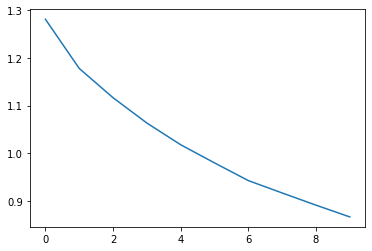

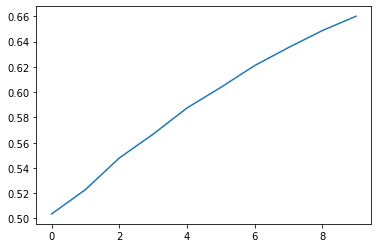

In [4]:
if __name__ == '__main__':
	train_path = 'data/train.tsv'
	test_path = 'data/test.tsv'
	vocab_path = 'data/vocab.txt'

	train_data = pd.read_csv(train_path, sep='\t')
	test_data = pd.read_csv(test_path, sep='\t')
	vocab = make_vocab(vocab_path, train_data)
	#model = torch.load('model.out')							#모델 불러오기

	device = torch.device('cuda:0')							#0번째 GPU사용

	max_len = 50											#너무 길어지면 RNN이 잘 작동하지 않음
	input_size = len(vocab)
	embed_size = 50
	hidden_size = 100
	output_size = 5
	batch_size = 1024
	epochs = 10
	lr = 0.001

	x_train, y_train, x_test = read_data(train_data, test_data, vocab, max_len)
	
	model, loss_total, acc_total = train(x_train, y_train, input_size, embed_size, hidden_size, output_size, batch_size, epochs, lr, device)
	draw_graph(loss_total)
	draw_graph(acc_total)
	predict = test(model, x_test, batch_size, device)
	save_submission(predict)
